<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/seq2seq_Part_B_Using_LSTM_layer_in_a_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part B: Using LSTM layer in a Recurrent Neural Network

Welcome to the **Part B** of Seq2Seq Learning Tutorial Series.
In this tutorial, we will use several Recurrent Neural Network models to solve the sample Seq2Seq problem introduced in **Part A**.

We will use **LSTM** as the Recurrent Neural Network layer in Keras.

If you would like to follow up all the tutorials, please **subcribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Thank you!

# References:


**Blogs**:

* [tf.keras.layers.LSTM official website](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

* [A ten-minute introduction to sequence-to-sequence learning in Keras by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

* [How to Develop an Encoder-Decoder Model with Attention in Keras by Jason Brownlee](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)

**Presentations:**

* [LSTM from a programmer's perspective by Murat Karakaya Akademi](https://github.com/kmkarakaya/ML_tutorials/raw/bf15d1d5aebd23e05420c12f3c954abea9204b1f/ppt/HOW%20KERAS%20LSTM%20WORKS.pptx)

**Videos:**
* [LSTM from scratch by Murat Karakaya Akademi](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM intro by Murat Karakaya Akademi](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Recap LSTM outputs by Murat Karakaya Akademi](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)


# Preparation

In [1]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.3.0
tf.keras version: 2.4.0


In [3]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

time: 177 µs


In [4]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

time: 51.4 ms


In [5]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=100, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	print('some examples...')
	for _ in range(10):
		X,y = get_reversed_pairs(n_timesteps, n_features)
		yhat = model.predict(X, verbose=0)
		print('Input',one_hot_decode(X[0]),
					'Expected:', one_hot_decode(y[0]), 
						'Predicted', one_hot_decode(yhat[0]),
							'', array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])) )
	


time: 37.5 ms


In [6]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 54 ms


# REMINDER:
* This is the **Part B** of the Seq2Seq Learning series.

* **Please check out the previous part** to refresh the necessary background knowledge in order to follow this part with ease.

# SEQ2SEQ LEARNING SERIES:


You can access all my **SEQ2SEQ Learning** videos on **[Murat Karakaya Akademi Youtube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid)** in [ENGLISH](https://www.youtube.com/playlist?list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww) or in [TURKISH](https://www.youtube.com/playlist?list=PLQflnv_s49v97hDXtCo4mgje_SEiJ0_hH)

You can access to [my blog on Medium](https://medium.com/@kmkarakaya)

**Part A: AN INTRODUCTION TO SEQ2SEQ LEARNING AND A SAMPLE SOLUTION WITH MLP NETWORK** 
 
   * YouTube Videos in [ENGLISH](https://youtu.be/9TEPkRLhgSc) or [TURKISH](https://youtu.be/p2QlkuV4ito) / [Medium Post](https://medium.com/@kmkarakaya/part-a-introduction-to-seq2seq-learning-a-sample-solution-with-mlp-network-95dc0bcb9c83?sk=2063e3c62b1989efedf6625ac626c2ee) / [Colab Notebook](https://colab.research.google.com/drive/1fffqeeJsY89LuxsEl_7Re33nCWGusjCj?usp=sharing)

**Part B: SEQ2SEQ LEARNING WITH RECURRENT NEURAL NETWORKS (LSTM)** 

   * YouTube Video in [ENGLISH](https://youtu.be/7L5bkMu0Pgg) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-b-using-lstm-layer-in-a-recurrent-neural-network-9be629bb71e2?source=friends_link&sk=0b6e0f34592100b991664c55061ca394) / [Colab Notebook](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing)


**Part C: SEQ2SEQ LEARNING WITH A BASIC ENCODER DECODER MODEL** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing)

**Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing)

**Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1DtOpSacgqJ1hDQ3GSx0BZgnQHrjwJAsy?usp=sharing)

**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing)

**Part G: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J?usp=sharing)


**Part H: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + LUONG ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1N0ycXm7Lq3jWzbJERRy6rwL1Ux4hmlWM?usp=sharing)


# WHY WE HAVE SO MANY PARTS?

* Our aim is to code an Encoder Decoder Model with Attention. 
* However, I would like to develop the solution by showing the shortcomings of other possible approaches.
* Therefore, in the first 2 parts, we will observe that initial models have their own weakness.
* We also understand why Encoder Decoder paradigm is so successful.

**So, please patiently follow the parts as we develop a better solution :)**

# A Simple Seq2Seq Problem: The reversed sequence problem
Assume that:
* We are given a **parallel data set** including X (input) and y (output) such that X[i] and y[i] have some relationship

<br>

In that tutorial, I will **generate** X and y parallel datasets such that **y sequence** will be  **the reverse of** the given **X sequence**. For example,

* **Given sequence** X[i] length of 4:

 X[i]=[3, 2, 9, 1]

* **Output sequence** (y[i]) is the **reversed** input sequence (X[i])  

 y[i]=[1, 9, 2, 3]

I will call this parallel dataset: "**the reversed sequence problem**"

<br>

In real life (like *Machine Language Translation, Image Captioning*, etc.), we are ***given*** (or ***build***) a **parallel dataset**: X sequences and corresponding y sequences

* However, to set up an ***easily traceable*** example, I opt out to set **y sequences as the reversed of X sequences**

* However, you can create X and y parallel datasets as you wish: *sorted, reverse sorted, odd or even numbers selected*, etc.

* We use the **parallel data set** to train a **seq2seq** model which would learn 

  * how to **convert/transform an input sequence from X 
to an output sequence in y**


**IMPORTANT**: 
* In the reversed sequence problem, **the input & output sequence lengths are fixed and same**. 
* **In PART E**, we will change the problem and the solution such that we will be dealing with variable-length sequnces after we built the encoder-decoder model. 

## Configure the problem
* **Number of Input Timesteps:** how many tokens / distict events /numbers / word etc in the input sequence 
* **Number of Features:** how many features/dimensions used to represent one tokens / distict events / numbers / word etc
* Here, we use one-hot encoding to represent the integers.
* The **length** of the one-hot coding vector is **Number of Features**
* Thus, the greatest integer will be **Number of Features-1**
* When **Number of Features=10** the **greatest integer will be 9** and will be represents as **[0 0 0 0 0 0 0 0 0 1]**



In [7]:
#@title Configure problem

n_timesteps =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  #@param {type:"integer"}
#each output sample has 2 values padded with 0

# generate random sequence
X,y = get_reversed_pairs(n_timesteps,  n_features, verbose=True)
# generate datasets
train_size= 2000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps,n_features , verbose=True)




Sample X and y

In raw format:
X=[1, 9, 1, 3], y=[3, 1, 9, 1]

In one_hot_encoded format:
X=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
y=[[0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]]

Generated sequence datasets as follows
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)
time: 83 ms


# Before starting, **you need to know**:
* Python
* Keras/TF
* Deep Neural Networks
* **Recurrent Neural Network concepts**
* **LSTM** parameters and outputs
* Keras Functional API

If you would like to refresh your knowledge about above topics please check Murat Karakaya Akademi resources on [YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid) / [Medium](https://medium.com/@kmkarakaya) / COLAB 


# PART B: Using LSTM layer in a Recurrent Neural Network 

In Part A, we observed that **Multi-Layer Perceptron (MLP)** does not perform well. Actually MLP is **not able to learn** Seq2Seq Learning.
The main reason is that MLP pays attention all its inputs *equally* and is **not aware of** *time dimensionality* of the input-output relation. 
Thus, MLP **can not relate** input with output understanding the **sequence order** (***time dimension***)

Therefore, in this part, we will create several models using **Recurrent Neural Networks (RNNs)**. In Keras, we have  3 kinds of implementation of RNNs. I opt out using **LSTM**.



## Quick LSTM reminder:

LSTM has 3 important parameters (for the time being!)

* **units**: Positive integer, dimensionality of the output space
* **return_sequences**: Boolean, whether to return the last output. in the output sequence, or the full sequence. Default: False.
* **return_state**: Boolean, whether to return the last state in addition to the output. Default: False.

The first parameter (**units**) indicates the **dimension** of the **output** vector/matrix.

The last 2 parameters (**return_sequences** and **return_state**) determines **what** the LSTM layer outputs.
LSTM can return 4 different sets of results/states according to the given parameters:


1.   **Default:** Last Hidden State  (Hidden State of the last time step)
2.   **return_sequences=True :** All Hidden States (Hidden State of ALL the time steps)
3.   **return_state=True     :** Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
4. **return_sequences=True + return_state=True:** All Hidden States (Hidden State of ALL the time steps) + Last Hidden State  + Last Cell State (Cell State of the last time step)


Using these 4 different results/states we can stack  LSTM layers in various ways






**IMPORTANT:** If you are **not familiar with LSTM**, you would like to consider refreshing your knowledge by watching / reading below resources:

**Videos:**
* [LSTM: From A Programmer's Perspective](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM: From A Programmer's Perspective](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [LSTM: Understanding Output Types](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)

* [LSTM: Understanding Number of Parameters](https://colab.research.google.com/drive/1Wd5340XLy-MC3YJPh3MkDnbGQ4JSnFwp?usp=sharing)




In [22]:

numberOfUnits=16#@param {type:"integer"}


time: 917 µs


## 1. LSTM with default output: 
* **Last Hidden State** (Hidden State of the last time step) 
* The **size** of the output vector will be as **numberOfUnits (16)**


### Let's begin with a model using **Single** LSTM Layer 
I will use **Keras Sequential API** for the sake of simplicity.
However, in the next part of the tutorial I will be using **Keras Functional API**

In the model, I use **RepeatVector** layer. This layer simply repeats the input **n times**. Here I make a **copy** of LSTM output as the number of ***n_timesteps*** so that Dense layer can have an output shape of (batch_size, 4, 10)! 

In [23]:
model_Single_LSTM_default_output = Sequential(name='model_Single_LSTM_default_output')
model_Single_LSTM_default_output.add(Input(shape=(n_timesteps, n_features)))

# Single LSTM Layer with default output
model_Single_LSTM_default_output.add(LSTM(numberOfUnits))
# Repeat the output of LSTM n_timesteps (4 in our example)
model_Single_LSTM_default_output.add(RepeatVector(n_timesteps))
# Dense layer recieves 4 x LSTM outputs as input vector
model_Single_LSTM_default_output.add(Dense(n_features, activation='softmax'))


model_Single_LSTM_default_output.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model_Single_LSTM_default_output.summary()

Model: "model_Single_LSTM_default_output"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 16)                1728      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4, 10)             170       
Total params: 1,898
Trainable params: 1,898
Non-trainable params: 0
_________________________________________________________________
time: 357 ms


We can run the compiled model with using the auxiliary function "**train_test()**" that I prepared for caring training and testing of a given model with Early Stopping mechanism. 

**IMPORTANT**: You can access and run [the full code on Colab](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing).

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 38.063, Test: 39.125


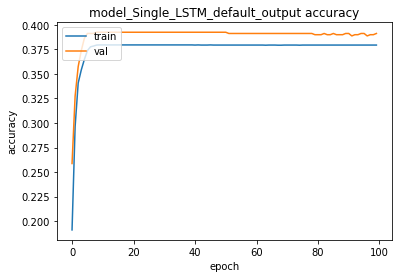

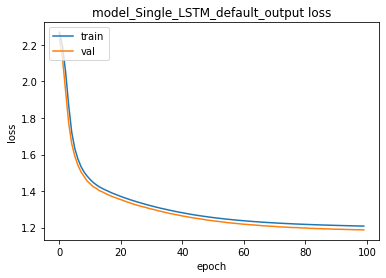

some examples...
Input [0, 6, 2, 5] Expected: [5, 2, 6, 0] Predicted [2, 2, 2, 2]  False
Input [3, 2, 1, 2] Expected: [2, 1, 2, 3] Predicted [2, 2, 2, 2]  False
Input [0, 1, 3, 1] Expected: [1, 3, 1, 0] Predicted [1, 1, 1, 1]  False
Input [0, 5, 9, 9] Expected: [9, 9, 5, 0] Predicted [9, 9, 9, 9]  False
Input [3, 6, 2, 9] Expected: [9, 2, 6, 3] Predicted [3, 3, 3, 3]  False
Input [6, 2, 9, 8] Expected: [8, 9, 2, 6] Predicted [8, 8, 8, 8]  False
Input [4, 8, 6, 5] Expected: [5, 6, 8, 4] Predicted [5, 5, 5, 5]  False
Input [2, 0, 7, 1] Expected: [1, 7, 0, 2] Predicted [1, 1, 1, 1]  False
Input [8, 8, 8, 2] Expected: [2, 8, 8, 8] Predicted [8, 8, 8, 8]  False
Input [9, 9, 4, 6] Expected: [6, 4, 9, 9] Predicted [9, 9, 9, 9]  False
time: 34 s


In [24]:
train_test(model_Single_LSTM_default_output, 
           X_train, y_train , X_test, y_test, 
           verbose=0)

**Observation**: PREDICTION ACCURACY is below 40% for even train data. Thus we need to **improve** this model by increasing its learning **capacity**.  

**Note**: In order to increment a model capacity & improve accuracy, ***in general***, we could increment
* number of units
*  number of layers
*  number of epochs
*  number of training samples

We can try all of them on above model.

For example we **incremented** the LSTM ***unit***, and noted the result below 

PREDICTION ACCURACY AT TEST DATA (%):
 * LSTM unit number **16**: 39.125
 * LSTM unit number **32**: 39.125
 * LSTM unit number **64**: 39.125


However, incrementing the LSTM unit number does not help!

Let's increment the **number of LSTM layers**


### Let's continue with a model using **Multiple** LSTM Layers
* As discussed above, LSTM layer can return 4 different sets of outputs.
* We will begin with a model containing multiple LSTM layer which are ***connected to each other*** by **default output** (last hidden states)
* That is, the **default output** (last hidden states) of the first LSTM layer is supplied to the next LSTM layer as **inputs**!

In [11]:
model_LSTM_default_output = Sequential(name='model_LSTM_default_output')
model_LSTM_default_output.add(Input(shape=(n_timesteps, n_features)))

# First LSTM layer
model_LSTM_default_output.add(LSTM(numberOfUnits))

# Repeat the output of the first LSTM n_timesteps (4 in our example)
model_LSTM_default_output.add(RepeatVector(n_timesteps))

# Second LSTM layer recieves 4 x LSTM outputs as input vector
# Reminder LSTM layer requires 3 dimension input! 
# (batch_size, timesteps, features)
# Therefore, we repeated the output of First LSTM layer
model_LSTM_default_output.add(LSTM(numberOfUnits))


model_LSTM_default_output.add(RepeatVector(n_timesteps))

# Repeat the output of Second LSTM n_timesteps (4 in our example)
# Dense layer recieves 4 x LSTM outputs as input vector
model_LSTM_default_output.add(Dense(n_features, activation='softmax'))


model_LSTM_default_output.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model_LSTM_default_output.summary()

Model: "model_LSTM_default_output"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1728      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 16)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________
time: 632 ms


We can train & test the **multi-layer** LSTM model using **default output** now:

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 38.087, Test: 39.125


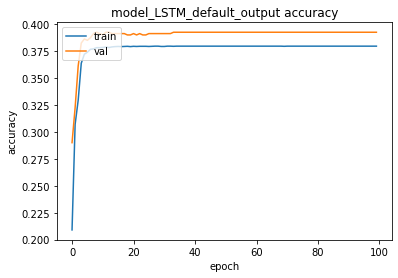

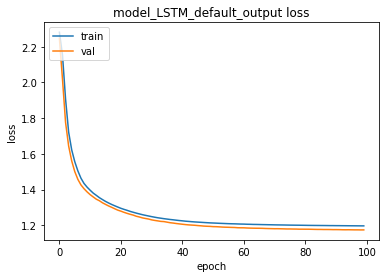

some examples...
Input [3, 1, 1, 1] Expected: [1, 1, 1, 3] Predicted [1, 1, 1, 1]  False
Input [6, 6, 2, 1] Expected: [1, 2, 6, 6] Predicted [6, 6, 6, 6]  False
Input [2, 4, 6, 3] Expected: [3, 6, 4, 2] Predicted [4, 4, 4, 4]  False
Input [4, 2, 7, 6] Expected: [6, 7, 2, 4] Predicted [6, 6, 6, 6]  False
Input [3, 1, 0, 8] Expected: [8, 0, 1, 3] Predicted [1, 1, 1, 1]  False
Input [6, 2, 6, 1] Expected: [1, 6, 2, 6] Predicted [6, 6, 6, 6]  False
Input [0, 6, 5, 6] Expected: [6, 5, 6, 0] Predicted [6, 6, 6, 6]  False
Input [8, 5, 4, 6] Expected: [6, 4, 5, 8] Predicted [4, 4, 4, 4]  False
Input [8, 6, 8, 3] Expected: [3, 8, 6, 8] Predicted [8, 8, 8, 8]  False
Input [2, 5, 9, 2] Expected: [2, 9, 5, 2] Predicted [2, 2, 2, 2]  False
time: 46.7 s


In [12]:
train_test(model_LSTM_default_output, X_train, y_train , X_test, y_test, verbose=0)

**Observation**: PREDICTION ACCURACY AT TEST DATA (%) has not changed at all!

Before trying to increse the capacity of this model, we can use **other ways of connecting** LSTM layers as follows:

## 2. A model containing  **Multiple** LSTM Layers by connecting them with **return_sequences=True** output
* As discussed above, LSTM layer can return 4 different sets of outputs.
* In the last model, we used the **default output** to connect 2 LSTM layers
* As a second option, we will create a model containing multiple LSTM layer which are ***connected to each other*** by **return_sequences=True output** (***all hidden states at each timesteps***)
* That is, the **all hidden states**  of the first LSTM layer is supplied to the next LSTM layer as **inputs**!
* Moreover, we also let the second LSTM layer return **all hidden states** as input to **dense** layer
* To connect the last LSTM layer with dense layer  we use **TimeDistributed** layer so that for **each timestep** of the second LSTM's output, dense layer will generate **one prediction**

In [13]:
#@title LSTM with return_sequences=True output

model_LSTM_return_sequences = Sequential(name='model_LSTM_return_sequences')
model_LSTM_return_sequences.add(Input(shape=(n_timesteps, n_features)))

# First LSTM layer with return_sequences=True
model_LSTM_return_sequences.add(LSTM(numberOfUnits,return_sequences=True))

# The output of the First LSTM has the 3 dimensions as expected by
# Second LSTM layer
# Thus, we do not need to use RepeatVector!
model_LSTM_return_sequences.add(LSTM(numberOfUnits,return_sequences=True))

# The output of the Second LSTM has the 3 dimensions 
# To supply the output to a dense layer
# we need to use TimeDistributed layer!
model_LSTM_return_sequences.add(TimeDistributed(Dense(n_features, activation='softmax')))
model_LSTM_return_sequences.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model_LSTM_return_sequences.summary()

Model: "model_LSTM_return_sequences"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 16)             1728      
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 16)             2112      
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 10)             170       
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________
time: 643 ms


We can train & test the **multi-layer** LSTM model using **return_sequences=True** now:

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 55.225, Test: 56.250


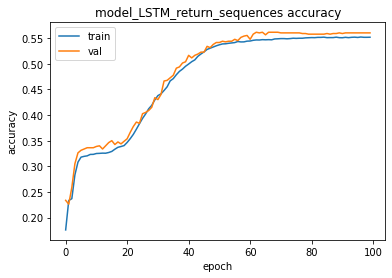

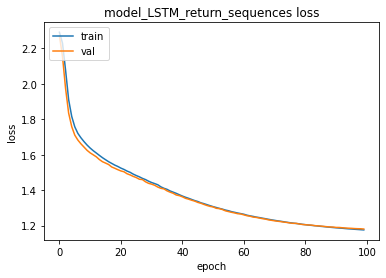

some examples...
Input [9, 4, 9, 0] Expected: [0, 9, 4, 9] Predicted [8, 4, 4, 9]  False
Input [0, 1, 4, 2] Expected: [2, 4, 1, 0] Predicted [3, 1, 1, 0]  False
Input [4, 1, 6, 5] Expected: [5, 6, 1, 4] Predicted [3, 1, 1, 4]  False
Input [4, 2, 5, 9] Expected: [9, 5, 2, 4] Predicted [3, 2, 2, 4]  False
Input [6, 7, 9, 6] Expected: [6, 9, 7, 6] Predicted [6, 7, 7, 6]  False
Input [8, 7, 2, 0] Expected: [0, 2, 7, 8] Predicted [8, 7, 7, 8]  False
Input [5, 1, 2, 2] Expected: [2, 2, 1, 5] Predicted [5, 5, 1, 5]  False
Input [1, 3, 4, 2] Expected: [2, 4, 3, 1] Predicted [5, 3, 3, 1]  False
Input [0, 9, 3, 0] Expected: [0, 3, 9, 0] Predicted [3, 9, 9, 0]  False
Input [4, 0, 6, 4] Expected: [4, 6, 0, 4] Predicted [3, 0, 0, 4]  False
time: 40.1 s


In [14]:
train_test(model_LSTM_return_sequences, X_train, y_train , X_test, 	y_test)

**Observations**: 
* PREDICTION ACCURACY AT TEST DATA (%) has improved 
from ***39*** to **56**

* This observation indicates that **how to connect multiple LSTM layers are important**.

* If we compare the latest model with the previous model it is clear that we are exchanging **more information** between LSTM layers and also with Dense layers. 

* **Even the parameter numbers are equal!**

* In the previous model, we have **16 distinct numbers** as the output of the LSTM, on the other hand, in the latest model we have **64 (4*16)  distinct numbers**. 

* Remember in the first model we **replicate** 16 numbers by 4 times using **RepeatVector** layer!
 
Let's continue trying **other ways of connecting** LSTM layers as follows:

## 3. A model containing  **Multiple** LSTM Layers by connecting them with **return_state=True** output
* As discussed above, LSTM layer can return 4 different sets of outputs.
* As a **third** option, a model containing multiple LSTM layer which are ***connected to each other*** by **return_state=True output** (last hidden **cell** states)
* Remember that when **return_state=True** LSTM layer will return 3 arrays of real numbers: 
1. LSTM_output (Last Hidden State)
2. Last Hidden State (again!) 
3. Last Cell State (Cell State of the last time step)

* So far we use ***Keras Sequentia API*** to create the models.
* But "**All layers in a Sequential model should have a single output tensor!**"
* For multi-output layers such as LSTM layer with **return_state=True**, we need to use the ***Keras functional API***!
* Before continue you would like to **refresh your knowledge** about the Keras functional API which will help you follow the rest of the tutorial 

* **Please note that**, we use **2nd and 3rd** outputs of the **First** LSTM layer to **initialize** the **next** LSTM layer's state = [Last Hidden State + Last Cell State]. Thus, the Second LSTM layer starts with the last state of the First LSTM layer

* As an input for the next LSTM layer, we can use the 1st output [LSTM_output (Last Hidden State)] but since it is **2D [batchsize,  features]** and LSTM layer requires **3D [batchsize, timesteps, features]** input, we need to **repeat** it by *timesteps*


In [15]:
#@title LSTM with return_state=True output
input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_state = Model(input,output,name='model_LSTM_return_state')
model_LSTM_return_state.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model_LSTM_return_state.summary()

Model: "model_LSTM_return_state"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 16), (None,  1728        input_4[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 4, 16)        0           lstm_5[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 4, 16)        2112        repeat_vector_3[0][0]            
                                                                 lstm_5[0][1

We can train & test the **multi-layer** LSTM model using **return_state=True** now:

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 93.988, Test: 89.500


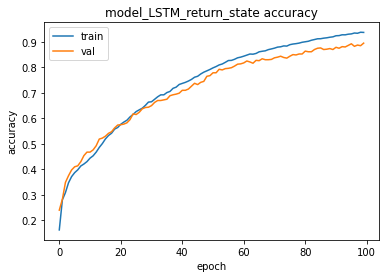

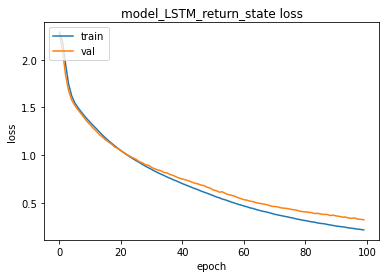

some examples...
Input [7, 2, 4, 1] Expected: [1, 4, 2, 7] Predicted [1, 4, 2, 7]  True
Input [5, 0, 0, 9] Expected: [9, 0, 0, 5] Predicted [9, 0, 0, 5]  True
Input [2, 3, 9, 4] Expected: [4, 9, 3, 2] Predicted [4, 9, 3, 2]  True
Input [9, 5, 9, 0] Expected: [0, 9, 5, 9] Predicted [0, 9, 9, 9]  False
Input [6, 3, 7, 0] Expected: [0, 7, 3, 6] Predicted [0, 7, 6, 6]  False
Input [9, 1, 5, 9] Expected: [9, 5, 1, 9] Predicted [9, 5, 1, 1]  False
Input [0, 7, 9, 3] Expected: [3, 9, 7, 0] Predicted [3, 9, 7, 0]  True
Input [1, 7, 1, 1] Expected: [1, 1, 7, 1] Predicted [1, 1, 1, 1]  False
Input [7, 0, 7, 5] Expected: [5, 7, 0, 7] Predicted [5, 7, 0, 4]  False
Input [7, 3, 0, 2] Expected: [2, 0, 3, 7] Predicted [2, 0, 3, 3]  False
time: 40.8 s


In [16]:
train_test(model_LSTM_return_state, X_train, y_train , X_test, 	y_test)

**Observations**: 
* PREDICTION ACCURACY AT TEST DATA (%) has improved 
from **39** to **56** to **90**

* Again this observation indicates that **how to connect** multiple LSTM layers is **important**.

* If we compare the latest model with the previous models it is clear that we are exchanging **more information** between LSTM layers **even though the number of parameters  is same!**

* **Note that** we do **not only** provide the output of previous LSTM layer to the next one, but we **also** provide the **last state of the previous LSTM** layer to the next LSTM layer as the **initial state**!

* In the **previous models** we have **only provide inputs** to the next layer, on the other hand, in the **latest model** we have also provided **initial values for hidden and cell states **of the next LSTM layer as well! 

**Notice that** we still **replicate** the hidden states by 4 times using **RepeatVector** layer! 

In the next model, we will **change what we provide as input** to the next layer
 

## 4. A model containing  **Multiple** LSTM Layers by connecting them with **return_sequences=True & return_state=True** output
* As discussed above, LSTM layer can return **4** different sets of outputs.
* As the **last** option, a model containing multiple LSTM layer which are ***connected to each other*** by **return_sequences=True & return_state=True** 
* Remember that when **return_sequences=True & return_state=True**  LSTM layer will return **3 arrays** of real numbers: 
1. All Hidden States (Hidden State of ALL the time steps)
2. Last Hidden State (Hidden State of the last time step)
3. Last Cell State (Cell State of the last time step)


* As an input for the next LSTM layer we can use the 1st output [All Hidden States] but since it is **3D [batchsize, timesteps, features]**  we do not need to use **RepeatVector** as we did above.

* The second and the third outputs will be used as the initial states to the Second LSTM layer.

In [17]:
input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_sequences_return_state = Model(input,output,
                                name='model_LSTM_all_state_h_return_state')
model_LSTM_return_sequences_return_state.compile(loss='categorical_crossentropy', 
                                                 optimizer='adam',
                                                 metrics=['accuracy'])
model_LSTM_return_sequences_return_state.summary()

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 4, 16), (Non 1728        input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 4, 16)        2112        lstm_7[0][0]                     
                                                                 lstm_7[0][1]                     
                                                                 lstm_7[0][2]                     
________________________________________________________________

training for  100  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
100  epoch training finished...

PREDICTION ACCURACY (%):
Train: 99.750, Test: 97.375


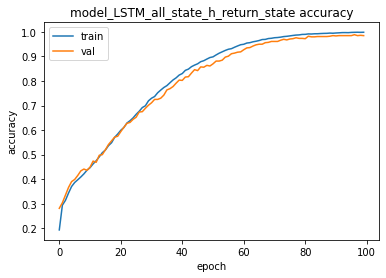

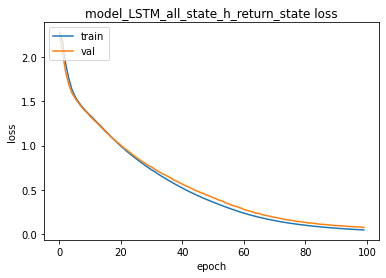

some examples...
Input [2, 7, 1, 1] Expected: [1, 1, 7, 2] Predicted [1, 1, 7, 2]  True
Input [4, 4, 5, 3] Expected: [3, 5, 4, 4] Predicted [3, 5, 4, 4]  True
Input [1, 7, 9, 7] Expected: [7, 9, 7, 1] Predicted [7, 9, 7, 1]  True
Input [7, 5, 1, 3] Expected: [3, 1, 5, 7] Predicted [3, 1, 5, 7]  True
Input [0, 6, 9, 0] Expected: [0, 9, 6, 0] Predicted [0, 9, 6, 0]  True
Input [0, 5, 7, 4] Expected: [4, 7, 5, 0] Predicted [4, 7, 5, 0]  True
Input [5, 2, 3, 1] Expected: [1, 3, 2, 5] Predicted [1, 3, 2, 5]  True
Input [8, 9, 0, 6] Expected: [6, 0, 9, 8] Predicted [6, 8, 9, 8]  False
Input [1, 9, 8, 4] Expected: [4, 8, 9, 1] Predicted [4, 8, 9, 1]  True
Input [8, 4, 5, 0] Expected: [0, 5, 4, 8] Predicted [0, 5, 4, 8]  True
time: 39 s


In [18]:
train_test(model_LSTM_return_sequences_return_state, X_train, y_train , X_test, 	y_test)

**NOTES**: 
* PREDICTION ACCURACY AT TEST DATA (%) has improved (previous models: **39** **56** to **90**) to **97**

* Again this observation indicates that **how to connect** multiple LSTM layers is **important**.

* If we compare the latest model with the previous models it is clear that we are exchanging **more information** between LSTM layers **even though the number of parameters  is same!**

In the **latest model**, we have  provided 
* previous LSTM's **last hidden and cell states** as **initial values** to the next LSTM layer's hidden and cell states 
*  previous LSTM's **all hidden states as inputs**  to the next LSTM layer

In other words, **Second LSTM layer**:
* **starts** to operate with last hidden states and cell states of the First LSTM layer
*  **consumes** the First LSTM layer's all hidden states to produce the output

As a result, during training, 
*  Second LSTM layer is conditioned to produce expected outputs given the  First LSTM layer's outputs.
* First LSTM layer is conditioned to produce such outputs that Second LSTM layer would be successful in prediction.

Thus:

* We can argue that ***First LSTM layer encodes the input (X)*** in a represantation  that ***Second LSTM layer can decode*** it to produce the expected output (y)

* The encoded represantation of the input (X) in the last model is composed of the all hidden states + last hidden + cell states

* That is the **context vector** is [all hidden states + last hidden + cell states] of the First LSTM layer

* The **First LSTM layer is called as Encoder** whereas the **Second LSTM layer  is called as Decoder**

* We can use more LSTM layers to construct Encoder or Decoder as well



 

## Obervations:
* Last model seems to be succesful
* When n_timesteps is **4** Last model  is able to achive **97.3%** accuracy
* What if we set n_timesteps to **8**?
* What if we set n_timesteps to **16**?




## PREDICTION ACCURACY AT TEST DATA (%) FOR **4 MODELS** (100 Epochs 16 LSTM Cells) WITH **INCREASING INPUT TIMESTEPS**

Sequence Size=4
 * **38.625** - **54.875** -  **91.625** - **97.250**

Sequence Size=8
 * **29.625** - **34.688** -  **50.375** - **56.437**

Sequence Size=16
 * **23.344** - **23.281** -  **33.344** - **37.469**

All the models ***degrade*** their performance when we request them to deal with **longer sequences**!


### How to handle longer sequences? 
**Generic** Solution in ANN: Increment the model capacity!

In order to increment a model capacity & improve accuracy, we could
* increment number of units
* increment number of layers
* increment number of epochs
* increment number of training samples

However, even the length of the input sequence is increased a little bit (e.g. from 4 to 8), the model **can not catch up with** it to provide similar accuracy applying all above measures!

For example: when sequence size is 16, **doubling the LSTM cell numbers** to 32, last model performance **improves only  10%** (from 37.469% to 47.219%)


## CONCLUSIONS:
* LSTM cells and layers are designed to capture sequential relations
* Best result is achived with **LSTM layer using return_sequences & return_sate are True** 
* In general, using LSTM layers in a simple Feed Forward Neural Network model **does NOT accomplish** a scalable accurate solution
* LSTM layers **could NOT handle-remember-relate** ***longer*** sequences.

 

### Moreover: Input or/and Output sequence length would be NOT fixed!
* If we change the problem such that:
output sequence is the inverse of the input sequence **and** **only consists of the first appereance of duplicated numbers**!

**Ex:**
* INPUT: [3,2,3,5,2]
* OUTPUT: [2,5,3]

**Notice that**: 
* output sequences do **NOT** have a **fixed** length!
* output sequences **DO** have a **variable** length!

NOTE: 
1. **Input sequence** length would also be **variable**
2. Both  **Input and Output sequence** length could be **variable**!


**Ex:**
* Sentence Translation from language A to B
* **Each sentece** in language A and B has varying number of words!

**New Questions**:
* How can you **create** a model to handle v**ariable-length** input/output?
* How can you **train** such a model?

## A MITIGATING SOLUTION FOR VARIABLE INPUT/OUTPUT

* We can use **padding** -adding some special symbol (e.g. zero) **in front of** or **in the end of** each sequence such that all sequences has a equal length with the **maximum sequence length** in the dataset

* There are many drawbacks of this solution. Few of them:
1. **Waste** of space and computation power
2. In real life, sometimes we do **NOT** know the the **maximum sequence length** 
3. In some applications, input sequence is **continuous** (e.g. speech recognition). Thus, you can **NOT** wait until the end of sequence to process ( ie padding) it!


# A BETTER SOLUTION
* We can change the model structure!
* So far, we use a single model for training and inference
* In the next part, we will focus on how to create such a model, namely a basic Encoder Decoder Model.

# NEXT PART C: ENCODER DECODER ARCHITECTURE/DESIGN